100%|██████████| 2948/2948 [00:05<00:00, 557.55it/s]


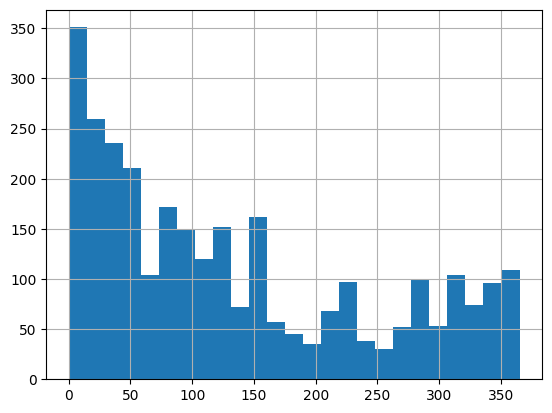

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, MandrillTripleImageDataset, MandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
hist = data["age"].hist(bins=25)

dataset = MandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, max_days=max_days)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm

from mandrill.models import InceptionResnetV1, RegressionModel, VGGFace
from mandrill.utils import split_dataset, load, save
from mandrill.losses import LinearDecayLoss

learning_rate = 1e-4
batch_size = 32
num_epochs = 50
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)

# Model
# backbone = InceptionResnetV1()
backbone = VGGFace()
model = RegressionModel(backbone, input_dim=backbone.output_dim, lin_start=1024, n_lin=0)

# Loss function
criterion = LinearDecayLoss() # nn.MSELoss()
val_criterion = LinearDecayLoss() # nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)

name="exp1_regression_exp_linear"
# model = load(model, "vgg_face", exp_name=name)


# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    train_loss = 0.0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = val_criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    
    # Print training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val L1: {val_loss:.4f}")

Using device: cuda


100%|██████████| 19/19 [00:04<00:00,  4.19it/s]


Epoch [1/50] - Train Loss: 0.3536 - Val L1: 0.3537


100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


Epoch [2/50] - Train Loss: 0.3246 - Val L1: 0.1758


100%|██████████| 19/19 [00:04<00:00,  4.63it/s]


Epoch [3/50] - Train Loss: 0.1134 - Val L1: 0.0614


100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


Epoch [4/50] - Train Loss: 0.0688 - Val L1: 0.0551


100%|██████████| 19/19 [00:04<00:00,  4.63it/s]


Epoch [5/50] - Train Loss: 0.0576 - Val L1: 0.0572


100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


Epoch [6/50] - Train Loss: 0.0521 - Val L1: 0.0481


100%|██████████| 19/19 [00:04<00:00,  4.71it/s]


Epoch [7/50] - Train Loss: 0.0478 - Val L1: 0.0443


100%|██████████| 19/19 [00:04<00:00,  4.67it/s]


Epoch [8/50] - Train Loss: 0.0443 - Val L1: 0.0442


100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


Epoch [9/50] - Train Loss: 0.0406 - Val L1: 0.0474


100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


Epoch [10/50] - Train Loss: 0.0350 - Val L1: 0.0436


100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


Epoch [11/50] - Train Loss: 0.0322 - Val L1: 0.0403


100%|██████████| 19/19 [00:04<00:00,  4.62it/s]


Epoch [12/50] - Train Loss: 0.0271 - Val L1: 0.0413


100%|██████████| 19/19 [00:04<00:00,  4.72it/s]


Epoch [13/50] - Train Loss: 0.0269 - Val L1: 0.0404


100%|██████████| 19/19 [00:04<00:00,  4.66it/s]


Epoch [14/50] - Train Loss: 0.0242 - Val L1: 0.0355


100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


Epoch [15/50] - Train Loss: 0.0190 - Val L1: 0.0390


100%|██████████| 19/19 [00:04<00:00,  4.75it/s]


Epoch [16/50] - Train Loss: 0.0154 - Val L1: 0.0352


100%|██████████| 19/19 [00:03<00:00,  4.84it/s]


Epoch [17/50] - Train Loss: 0.0142 - Val L1: 0.0385


100%|██████████| 19/19 [00:03<00:00,  4.80it/s]


Epoch [18/50] - Train Loss: 0.0119 - Val L1: 0.0330


100%|██████████| 19/19 [00:03<00:00,  4.89it/s]


Epoch [19/50] - Train Loss: 0.0118 - Val L1: 0.0399


100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


Epoch [20/50] - Train Loss: 0.0111 - Val L1: 0.0332


100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


Epoch [21/50] - Train Loss: 0.0095 - Val L1: 0.0333


100%|██████████| 19/19 [00:03<00:00,  4.85it/s]


Epoch [22/50] - Train Loss: 0.0082 - Val L1: 0.0327


100%|██████████| 19/19 [00:03<00:00,  4.91it/s]


Epoch [23/50] - Train Loss: 0.0070 - Val L1: 0.0314


100%|██████████| 19/19 [00:03<00:00,  4.81it/s]


Epoch [24/50] - Train Loss: 0.0058 - Val L1: 0.0339


100%|██████████| 19/19 [00:03<00:00,  4.83it/s]


Epoch [25/50] - Train Loss: 0.0051 - Val L1: 0.0316


100%|██████████| 19/19 [00:03<00:00,  4.95it/s]


Epoch [26/50] - Train Loss: 0.0053 - Val L1: 0.0302


100%|██████████| 19/19 [00:04<00:00,  4.75it/s]


Epoch [27/50] - Train Loss: 0.0054 - Val L1: 0.0304


100%|██████████| 19/19 [00:03<00:00,  4.82it/s]


Epoch [29/50] - Train Loss: 0.0040 - Val L1: 0.0304


100%|██████████| 19/19 [00:03<00:00,  4.86it/s]


Epoch [30/50] - Train Loss: 0.0042 - Val L1: 0.0293


100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


Epoch [31/50] - Train Loss: 0.0042 - Val L1: 0.0326


100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


Epoch [32/50] - Train Loss: 0.0046 - Val L1: 0.0299


100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


Epoch [34/50] - Train Loss: 0.0033 - Val L1: 0.0311


100%|██████████| 19/19 [00:03<00:00,  4.89it/s]


Epoch [35/50] - Train Loss: 0.0031 - Val L1: 0.0307


100%|██████████| 19/19 [00:03<00:00,  4.87it/s]


Epoch [36/50] - Train Loss: 0.0031 - Val L1: 0.0291


 45%|████▍     | 33/74 [00:27<00:33,  1.22it/s]


KeyboardInterrupt: 

Predicted Values: 47.865972593426704
Actual Values: 49.99999962747097
Prediction Error:  -2.1340270340442657



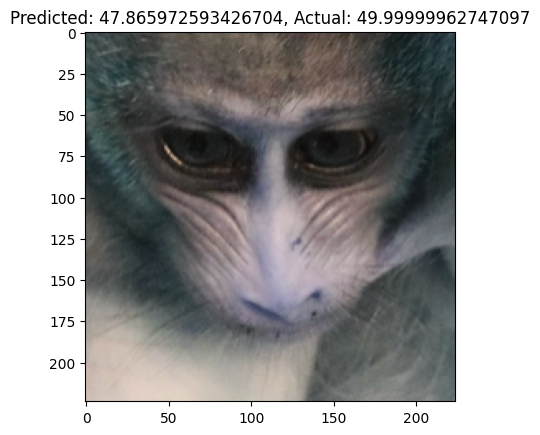

Predicted Values: 256.9800138473511
Actual Values: 344.99998927116394
Prediction Error:  -88.01997542381287



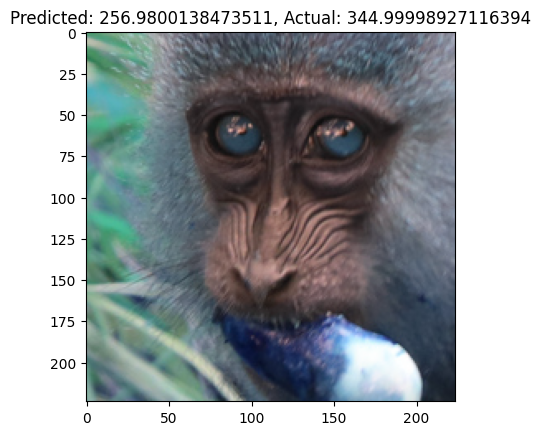

Predicted Values: 138.63720044493675
Actual Values: 164.00000095367432
Prediction Error:  -25.362800508737564



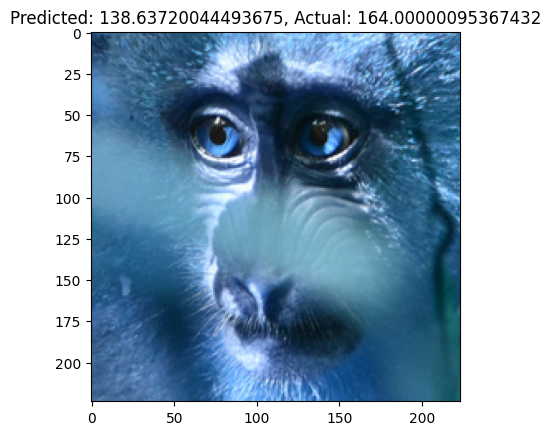

Predicted Values: 28.598913960158825
Actual Values: 39.999999701976776
Prediction Error:  -11.401085741817951



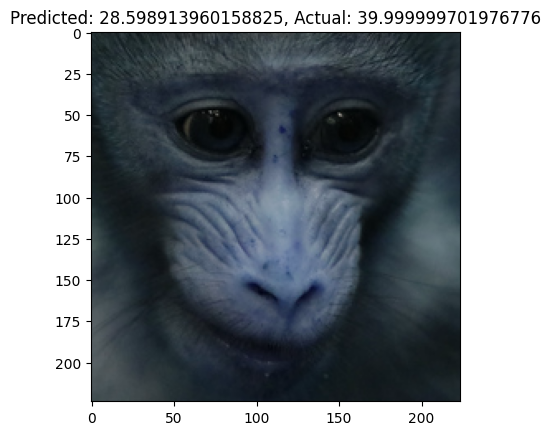

Predicted Values: 11.062094615772367
Actual Values: 10.999999782070518
Prediction Error:  0.062094833701848984



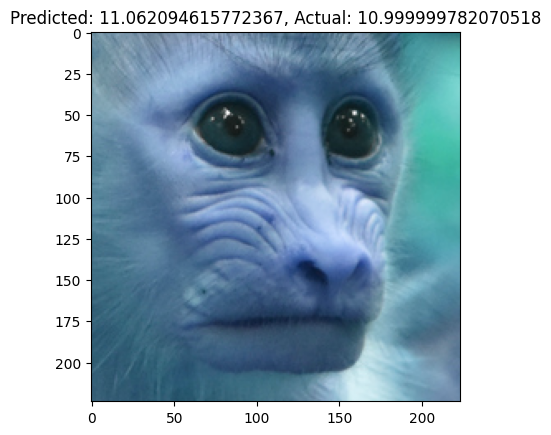

Predicted Values: 112.27873966097832
Actual Values: 111.00000515580177
Prediction Error:  1.2787345051765442



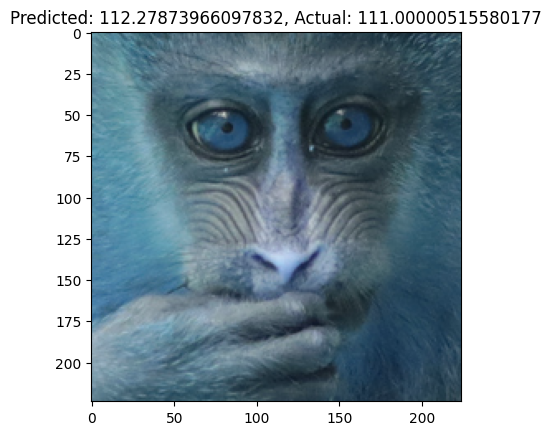

Predicted Values: 63.737638890743256
Actual Values: 53.00000123679638
Prediction Error:  10.737637653946877



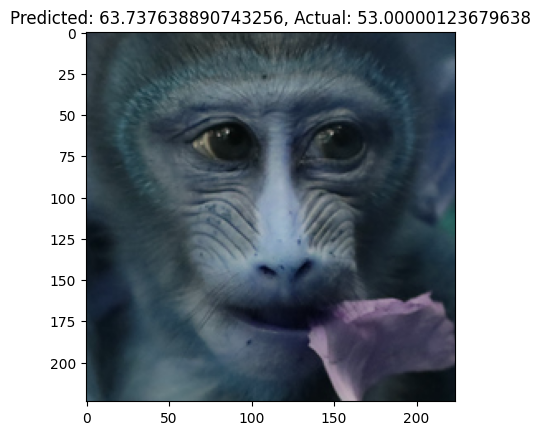

Predicted Values: 161.32019966840744
Actual Values: 182.99998939037323
Prediction Error:  -21.67978972196579



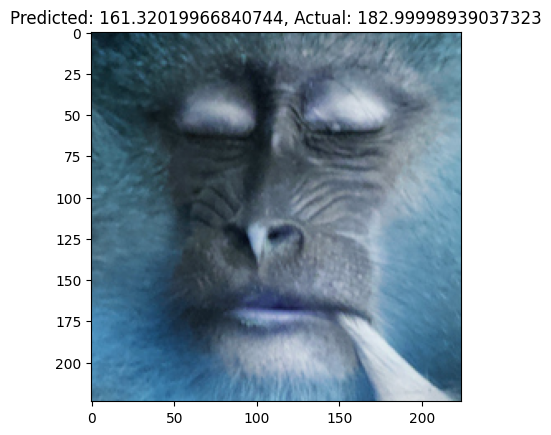

Predicted Values: 42.590942569077015
Actual Values: 8.000000212341547
Prediction Error:  34.59094235673547



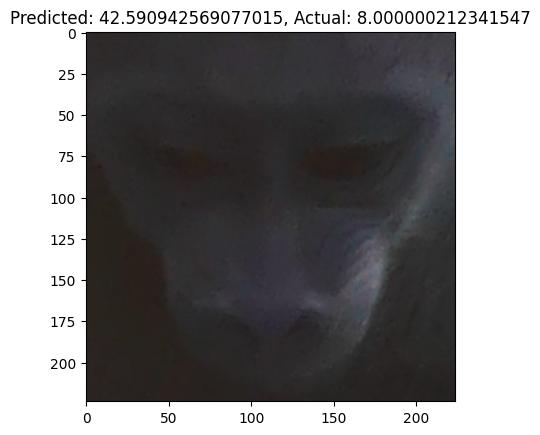

Predicted Values: 117.65457198023796
Actual Values: 98.99999871850014
Prediction Error:  18.654573261737823



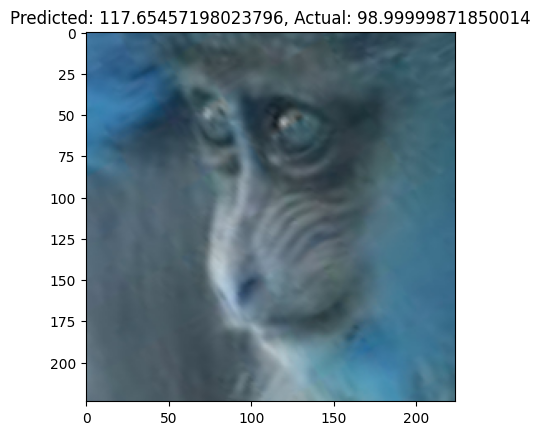

Absolute age error (in days):  0.8007264070852139  std:  34.61315969201432


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load

# model = load(model, "vgg_face", exp_name="exp1_regression")

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 10

age_errors = []
age_truth = []
age_predicted = []

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    predicted_values = outputs.squeeze().detach().cpu().numpy() * 365
    actual_values = targets.squeeze().cpu().numpy() * 365
    
    age_errors.append(predicted_values - actual_values)
    age_truth.append(actual_values)
    age_predicted.append(predicted_values)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", predicted_values)
    print("Actual Values:", actual_values)
    print("Prediction Error: ", predicted_values - actual_values)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {predicted_values}, Actual: {actual_values}")
    plt.show()

age_errors = np.array(age_errors)
print("Absolute age error (in days): ", np.mean(age_errors), " std: ", np.std(age_errors))

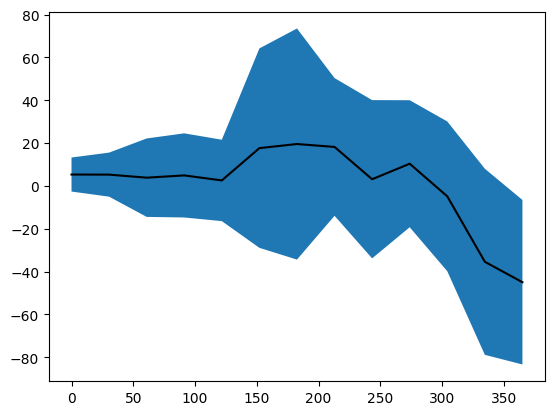

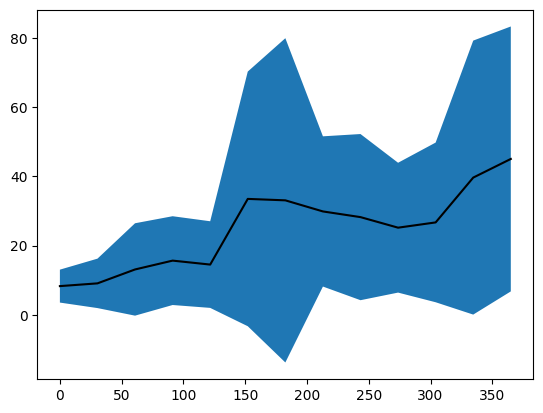

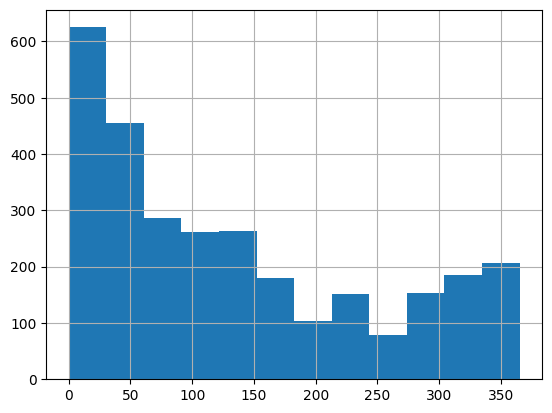

In [4]:
# Histogram with x being the real age and y being the error on this age
# Plotting the histogram

def group_by(x, n_bins):
    step = np.max(x) / n_bins
    x = np.array(x)
    for i in range(n_bins+1):
        nx = i*step
        px = max(0, (i-1)*step)
        x[np.logical_and(x <= nx, x > px)] = nx
    x[np.logical_and(x <= np.max(x), x > (n_bins*step))] = np.max(x)
    return x.tolist()

def bin_errors(x, y):
    bins = np.unique(x)
    y_mean = []
    y_err = []
    y = np.array(y)
    for b in bins:
        y_bin = y[x == b]
        y_mean.append(np.mean(y_bin))
        y_err.append(np.std(y_bin))
    return np.array(y_mean), np.array(y_err)

n_bins = 12

x = age_truth
y = age_errors

sorted_lists = sorted(zip(x, y))
sorted_x, sorted_y = zip(*sorted_lists)

def display_error_curve(x, y, n_bins):
    x = group_by(x, n_bins)
    y, y_err = bin_errors(x, y)
    x = np.unique(x)

    plt.plot(x, y, 'k-', label='Prediction error')
    plt.fill_between(x, y-y_err, y+y_err)
    plt.show()

display_error_curve(sorted_x, sorted_y, n_bins)
display_error_curve(sorted_x, abs(np.array(sorted_y)), n_bins)

# Distribution of image according to the age
hist = data["age"].hist(bins=n_bins)

In [ ]:
from mandrill.utils import save
save(model, "vgg_face", exp_name=name)
print("saved")